# Hull Tactical Market Prediction — Exploratory Data Analysis
This notebook reproduces the EDA steps and plots (matplotlib + Altair).

In [ ]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, re, math, warnings
from pathlib import Path

warnings.filterwarnings("ignore")

train = pd.read_csv(r"data\hull-tactical-market-prediction\train.csv")
test  = pd.read_csv(r"data\hull-tactical-market-prediction\train.csv")

meta_cols = ["date_id","forward_returns","risk_free_rate","market_forward_excess_returns"]
feature_cols = [c for c in train.columns if c not in meta_cols]

def group_prefix(col):
    import re
    m = re.match(r"^([A-Za-z]+)\d+$", col)
    if m: return m.group(1)
    return "other"

groups = pd.Series({c:group_prefix(c) for c in feature_cols}, name="group")
    

In [6]:

basic_summary = pd.DataFrame({
    "n_rows": [train.shape[0]],
    "n_cols": [train.shape[1]],
    "date_min": [int(train["date_id"].min())],
    "date_max": [int(train["date_id"].max())],
    "feature_count": [len(feature_cols)],
    "feature_groups": [", ".join(sorted(set(groups.values)))],
})
basic_summary
    

,n_rows,n_cols,date_min,date_max,feature_count,feature_groups
0,8990,98,0,8989,94,"D, E, I, M, P, S, V"


In [7]:

missing_pct = train[feature_cols].isna().mean().sort_values(ascending=False)
missing_by_group = pd.DataFrame({"group": groups, "missing_pct": train[feature_cols].isna().mean()}).groupby("group")["missing_pct"].agg(["mean","max","min","count"]).sort_values("mean", ascending=False)
missing_by_group
    

,mean,max,min,count
group,,,,
M,0.254938,0.617019,0.111902,18
S,0.202429,0.637709,0.111902,12
V,0.198254,0.672859,0.111902,13
E,0.152786,0.775195,0.111902,20
P,0.127389,0.182202,0.111902,13
I,0.111902,0.111902,0.111902,9
D,0.000000,0.000000,0.000000,9


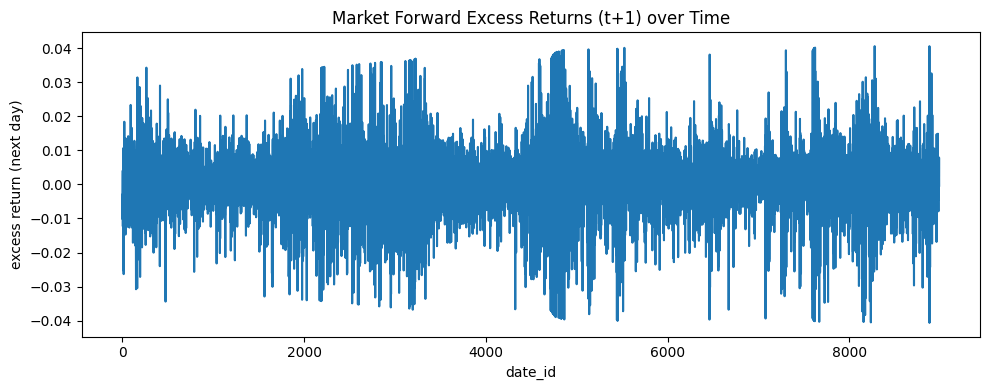

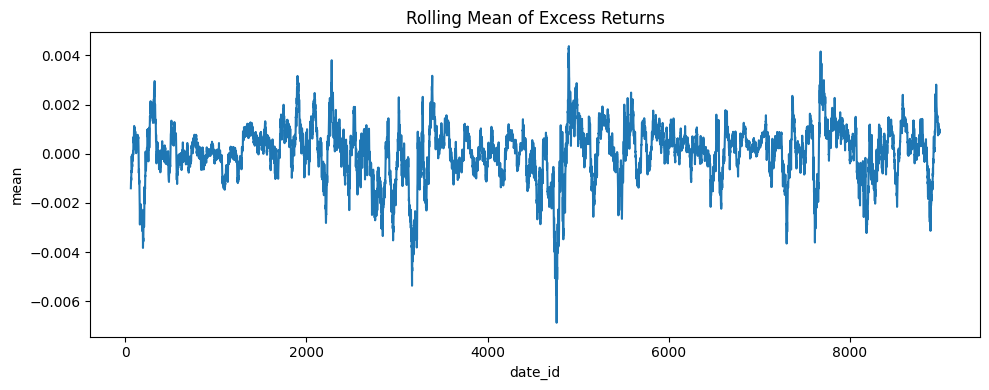

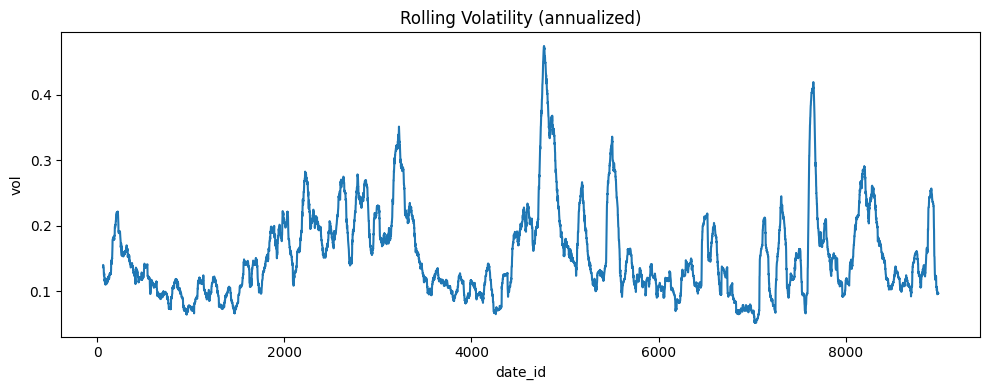

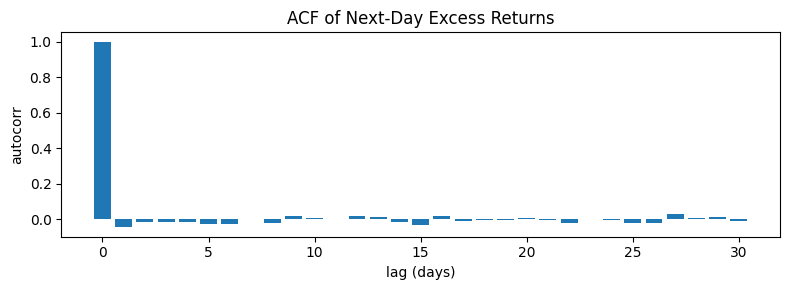

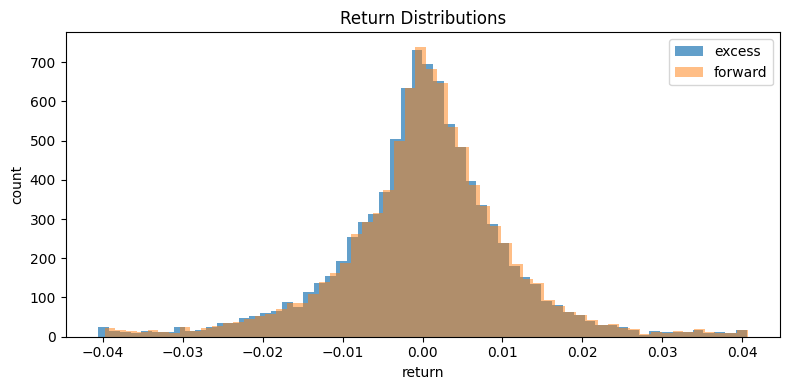

In [8]:

y_all = train["forward_returns"].rename("forward_returns")
y_ex  = train["market_forward_excess_returns"].rename("excess_returns")

win_mu, win_vol = 63, 63
roll_mu = y_ex.rolling(win_mu).mean()
roll_vol = y_ex.rolling(win_vol).std() * np.sqrt(252)

fig1 = plt.figure(figsize=(10,4)); y_ex.plot(); plt.title("Market Forward Excess Returns (t+1) over Time"); plt.xlabel("date_id"); plt.ylabel("excess return (next day)"); plt.tight_layout(); plt.show()
fig2 = plt.figure(figsize=(10,4)); roll_mu.plot(); plt.title("Rolling Mean of Excess Returns"); plt.xlabel("date_id"); plt.ylabel("mean"); plt.tight_layout(); plt.show()
fig3 = plt.figure(figsize=(10,4)); roll_vol.plot(); plt.title("Rolling Volatility (annualized)"); plt.xlabel("date_id"); plt.ylabel("vol"); plt.tight_layout(); plt.show()

def acf_series(x, max_lag=30):
    x = x.values.astype(float)
    x = x - np.nanmean(x)
    x = x[np.isfinite(x)]
    denom = np.dot(x, x)
    return pd.Series([1.0] + [np.dot(x[:-lag], x[lag:])/denom for lag in range(1, max_lag+1)], index=range(0, max_lag+1), name="acf")

acf_vals = acf_series(y_ex.fillna(0), 30)
plt.figure(figsize=(8,3)); plt.bar(acf_vals.index, acf_vals.values); plt.title("ACF of Next-Day Excess Returns"); plt.xlabel("lag (days)"); plt.ylabel("autocorr"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4)); plt.hist(y_ex.dropna(), bins=60, alpha=0.7, label="excess"); plt.hist(y_all.dropna(), bins=60, alpha=0.5, label="forward"); plt.title("Return Distributions"); plt.xlabel("return"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()
    

In [9]:

def corr_with_target(df, cols, target):
    vals = []
    for c in cols:
        s = df[[c, target]].dropna()
        if len(s) < 100:  # skip too sparse
            continue
        corr = s[c].corr(s[target])
        vals.append((c, corr, len(s)))
    return pd.DataFrame(vals, columns=["feature","pearson_corr","n_used"]).sort_values("pearson_corr")

corr_df = corr_with_target(train, feature_cols, "market_forward_excess_returns")
corr_df["abs_corr"] = corr_df["pearson_corr"].abs()
top_abs = corr_df.sort_values("abs_corr", ascending=False).head(20)
top_abs
    

,feature,pearson_corr,n_used,abs_corr
50,M4,-0.066454,7984,0.066454
85,V13,0.062418,7479,0.062418
38,M1,0.046339,3443,0.046339
76,S5,0.040106,7479,0.040106
73,S2,-0.037738,7984,0.037738
0,D1,0.034185,8990,0.034185
1,D2,0.034185,8990,0.034185
48,M2,0.033312,5773,0.033312
82,V10,0.032735,2941,0.032735
26,E7,-0.032476,2021,0.032476


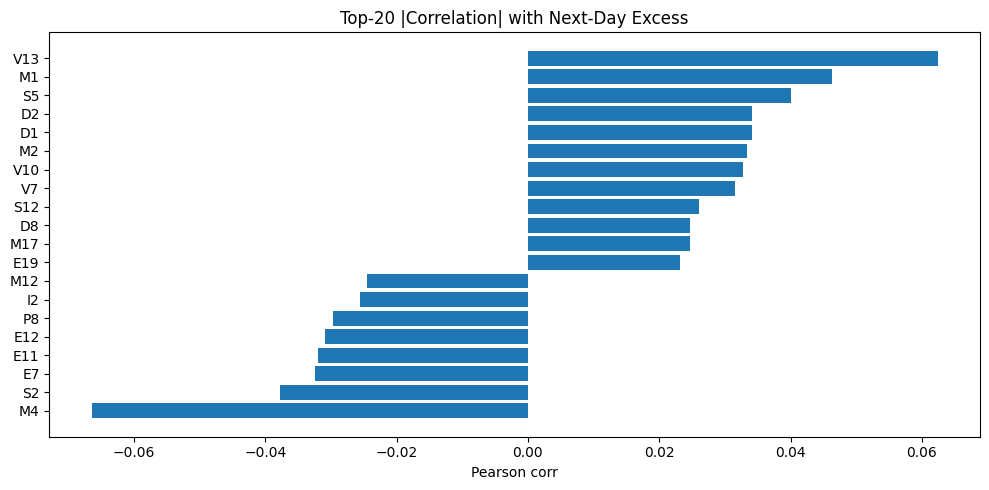

In [10]:

import matplotlib.pyplot as plt
order = top_abs.sort_values("pearson_corr")["feature"]
vals  = top_abs.set_index("feature").loc[order]["pearson_corr"]
plt.figure(figsize=(10,5)); plt.barh(range(len(vals)), vals.values); plt.yticks(range(len(vals)), order); plt.title("Top-20 |Correlation| with Next-Day Excess"); plt.xlabel("Pearson corr"); plt.tight_layout(); plt.show()
    

In [11]:

def decile_analysis(df, feature, target):
    tmp = df[[feature, target]].dropna().copy()
    tmp["decile"] = pd.qcut(tmp[feature], 10, labels=False, duplicates="drop")
    agg = tmp.groupby("decile")[target].agg(["mean","median","count"])
    agg["annualized_mean"] = agg["mean"] * 252
    agg["annualized_median"] = agg["median"] * 252
    agg["feature"] = feature
    return agg.reset_index()

top3 = top_abs["feature"].head(3).tolist()
deciles_df = pd.concat([decile_analysis(train, f, "market_forward_excess_returns") for f in top3], ignore_index=True)
deciles_df
    

,decile,mean,median,count,annualized_mean,annualized_median,feature
0,0,0.001723,0.002771,799,0.434181,0.698222,M4
1,1,-0.000027,0.000892,798,-0.006803,0.224690,M4
2,2,0.000271,0.000326,798,0.068217,0.082031,M4
3,3,0.000224,0.000596,799,0.056432,0.150226,M4
4,4,-0.000227,0.000034,798,-0.057294,0.008608,M4
5,5,0.000142,0.000310,798,0.035868,0.078182,M4
6,6,-0.000503,-0.000053,799,-0.126831,-0.013414,M4
7,7,-0.000327,-0.000088,798,-0.082328,-0.022115,M4
8,8,0.000727,0.000522,798,0.183112,0.131531,M4
9,9,-0.001314,-0.000541,799,-0.331174,-0.136346,M4


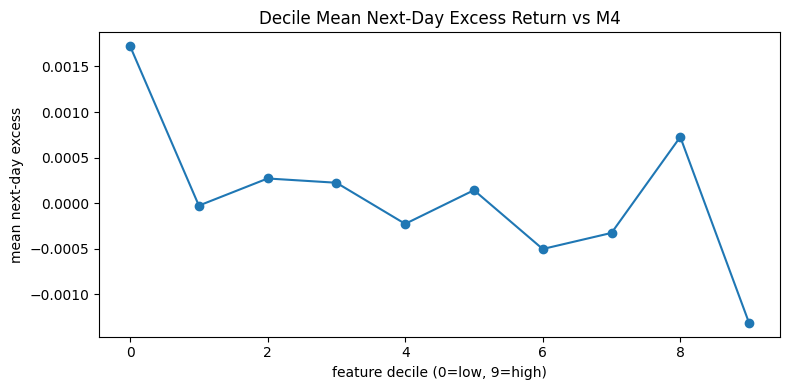

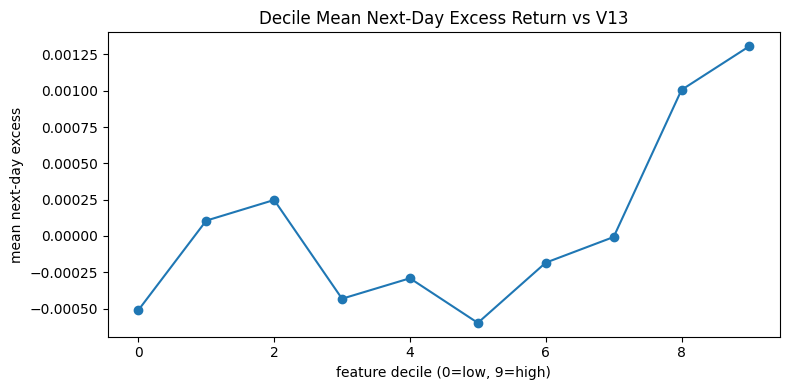

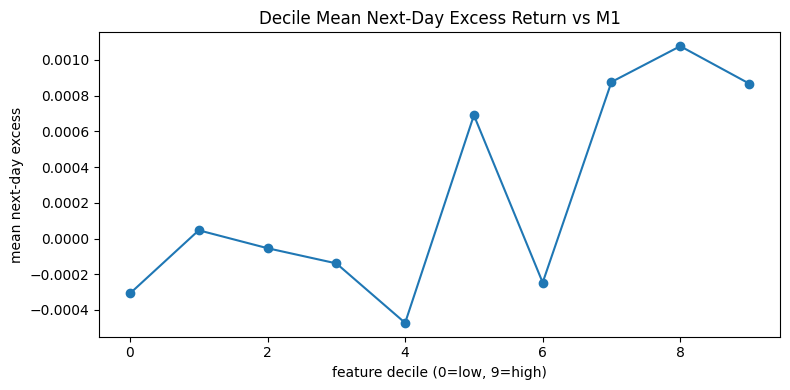

In [12]:

for f in top3:
    data = deciles_df[deciles_df["feature"]==f]
    plt.figure(figsize=(8,4)); plt.plot(data["decile"], data["mean"], marker="o"); plt.title(f"Decile Mean Next-Day Excess Return vs {f}"); plt.xlabel("feature decile (0=low, 9=high)"); plt.ylabel("mean next-day excess"); plt.tight_layout(); plt.show()
    

In [13]:

rv_21 = train["market_forward_excess_returns"].rolling(21).std()
rv_q = pd.qcut(rv_21, 3, labels=["low vol","med vol","high vol"])
reg_df = pd.DataFrame({"regime": rv_q, "y_ex": train["market_forward_excess_returns"]}).dropna()
reg_summary = reg_df.groupby("regime")["y_ex"].agg(["mean","median","count"])
reg_summary["annualized_mean"] = reg_summary["mean"] * 252
reg_summary
    

,mean,median,count,annualized_mean
regime,,,,
low vol,0.000136,0.000189,2990,0.034312
med vol,-0.000051,0.000272,2990,-0.012780
high vol,0.000105,0.000468,2990,0.026558


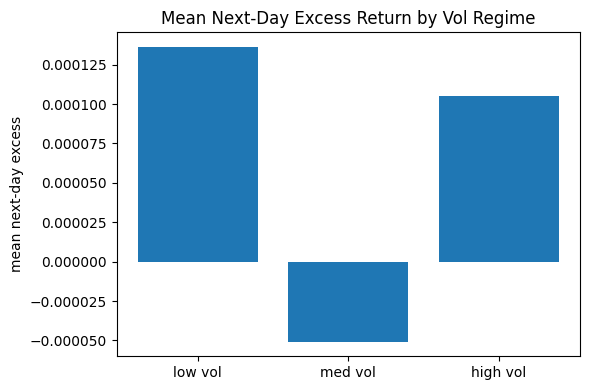

In [14]:

plt.figure(figsize=(6,4)); plt.bar(reg_summary.index.astype(str), reg_summary["mean"].values); plt.title("Mean Next-Day Excess Return by Vol Regime"); plt.ylabel("mean next-day excess"); plt.tight_layout(); plt.show()
    

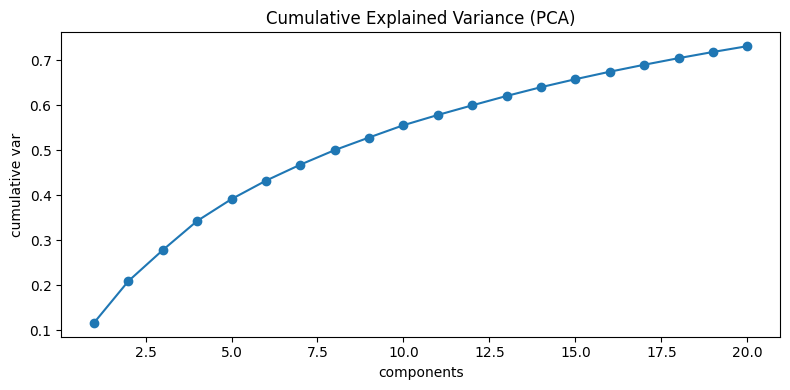

In [15]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X = train[feature_cols].apply(lambda s: s.fillna(s.median()), axis=0)
X_scaled = StandardScaler().fit_transform(X.values)
pca = PCA(n_components=min(20, X_scaled.shape[1])).fit(X_scaled)
evr = pca.explained_variance_ratio_
plt.figure(figsize=(8,4)); plt.plot(range(1, len(evr)+1), np.cumsum(evr), marker="o"); plt.title("Cumulative Explained Variance (PCA)"); plt.xlabel("components"); plt.ylabel("cumulative var"); plt.tight_layout(); plt.show()
    

In [16]:

try:
    import altair as alt
    alt.data_transformers.disable_max_rows()
    ts_df = pd.DataFrame({"date_id": train["date_id"], "excess": train["market_forward_excess_returns"], "rolling_mean": train["market_forward_excess_returns"].rolling(63).mean()}).dropna()
    brush = alt.selection_interval(encodings=["x"])
    ts_base = alt.Chart(ts_df).mark_line().encode(x="date_id:Q", y="excess:Q", tooltip=["date_id","excess"]).properties(height=200)
    ts_mean = alt.Chart(ts_df).mark_line().encode(x="date_id:Q", y="rolling_mean:Q", tooltip=["date_id","rolling_mean"]).properties(height=100)
    upper = ts_base.encode(x="date_id:Q").add_params(brush).transform_filter(brush)
    lower = ts_base.encode(y="excess:Q").properties(height=60)
    (alt.vconcat(upper, ts_mean, lower).resolve_scale(y="independent").properties(title="Interactive Excess Return & Rolling Mean")).display()

    corr_df_nb = corr_df.copy(); corr_df_nb["group"] = corr_df_nb["feature"].map(groups.to_dict()); corr_df_nb["abs_corr"] = corr_df_nb["pearson_corr"].abs()
    base = alt.Chart(corr_df_nb).transform_window(rank="rank(abs_corr):Q", sort=[alt.SortField("abs_corr", order="descending")])
    selector = alt.selection_point(fields=["group"], bind="legend")
    (base.mark_bar().encode(x=alt.X("abs_corr:Q", title="|corr|"), y=alt.Y("feature:N", sort="-x"), tooltip=["feature","group","pearson_corr","n_used"], opacity=alt.condition(selector, alt.value(1), alt.value(0.2)), color="group:N").transform_filter("datum.rank<=30").add_params(selector).properties(width=600, height=700, title="Top-30 feature correlations (interactive)")).display()

    # Decile line
    decile_long = deciles_df.rename(columns={"mean":"mean_return"})
    (alt.Chart(decile_long).mark_line(point=True).encode(x=alt.X("decile:O", title="feature decile"), y=alt.Y("mean_return:Q", title="mean next-day excess"), color="feature:N", tooltip=["feature","decile","mean_return","count"]).properties(title="Decile curves for top-3 features")).display()

    # Missingness heatmap
    miss_cols = missing_pct.head(20).index.tolist()
    miss_df = train[["date_id"] + miss_cols].copy()
    miss_long = miss_df.melt("date_id", var_name="feature", value_name="val"); miss_long["missing"] = miss_long["val"].isna().astype(int); miss_long = miss_long[miss_long["date_id"]<=1500]
    (alt.Chart(miss_long).mark_rect().encode(x=alt.X("date_id:Q", title="date_id (first 1500)"), y=alt.Y("feature:N", sort=miss_cols), tooltip=["date_id","feature","missing"], color=alt.Color("missing:Q", scale=alt.Scale(domain=[0,1]))).properties(width=700, height=400, title="Missingness heatmap (1=missing)")).display()
except Exception as e:
    print("Altair not available in this environment:", e)
    

alt.VConcatChart(...)

Altair not available in this environment: "Q" is not one of the valid encoding data types: O, N, Q, T, G.
For more details, see https://altair-viz.github.io/user_guide/encodings/index.html#encoding-data-types. If you are trying to use a column name that contains a colon, prefix it with a backslash; for example "column\:name" instead of "column:name".
